In [50]:
# math
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn

# Bert 
import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight


# specify GPU
device = torch.device("cuda")

### 

In [5]:
data = pd.read_csv("../dataset/spamdata_v2.csv")
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


We can see the dataset contains the label, and the Tex column contains the message feature.
Lets check the shape next...

In [8]:
data.shape

(5572, 2)

In [9]:
# check class distribution
data['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

### Train and test split

In [10]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['label'], 
                                                                    random_state=420, 
                                                                    test_size=0.3, 
                                                                    stratify=data['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=420, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

### Initialize BERT model and tokenizer

In [11]:
# import BERT-base pretrained model
bert_model_base = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [14]:
# sample data
text = ["the bert model", "example data for BERT model tuning"]

# encode text
sent_id = bert_tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

sent_id

{'input_ids': [[101, 1996, 14324, 2944, 102, 0, 0, 0], [101, 2742, 2951, 2005, 14324, 2944, 17372, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1]]}

### Using the tokenizer

<AxesSubplot:>

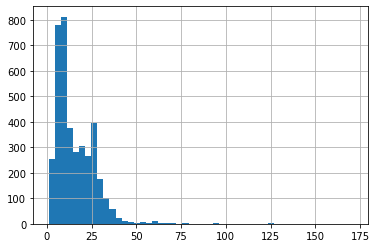

In [19]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 50)

We have to tokenize and encode the entries in the three sets we have created, The training, validation and test sets.

In [22]:

# Training Set
tokens_train = bert_tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Validation set
tokens_val = bert_tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Test set
tokens_test = bert_tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

Convert squences to Tensors, once again for all three the sets. 

In [23]:
# Training set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# Validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# Test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

Create dataloaders to combine the dataset and sampler

In [24]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=32)

Freeze parameters. 

In [28]:
for param in bert_model_base.parameters():
    param.requires_grad = False

### Initialize the model, build architecture.

In [32]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      self.dropout = nn.Dropout(0.1) # dropout layer
    
      self.relu =  nn.ReLU() # relu activation function

      self.fc1 = nn.Linear(768,512) # dense layer 1
      

      self.fc2 = nn.Linear(512,2) # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1) # softmax activation function

    #define the forward pass
    def forward(self, sent_id, mask):  
      _, cls_hs = self.bert(sent_id, attention_mask=mask) #pass the inputs to the model
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x) 

      x = self.fc2(x) # output layer
      x = self.softmax(x) # apply softmax activation
      return x

In [33]:
# Pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert_model_base)

# Push the model to GPU
model = model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)


AssertionError: Torch not compiled with CUDA enabled

/home/basdaniel3/miniconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Calculate the tensors from class weights.

In [39]:
#compute the class weights
class_wts = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
class_wts

array([0.57743559, 3.72848948])

In [ ]:
# convert class weights to tensor
weights = torch.tensor(class_wts, dtype = torch.float)
weights = weights.to(device)

# loss function
cross_entropy = nn.NLLLoss(weight = weights) 

We are going to define functions for the training and evaluations of the models. 

Training function

In [40]:
# function to train the model
def train():
  model.train()

  total_loss, total_accuracy = 0, 0
  # list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

Evaluation function

In [41]:
def evaluate():
  print("\nEvaluating\n")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

### Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model we can load in the next step
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

### Load the saved weights of the best model

In [43]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

FileNotFoundError: [Errno 2] No such file or directory: 'saved_weights.pt'

In [44]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

AssertionError: Torch not compiled with CUDA enabled

In [52]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

NameError: name 'preds' is not defined

In [51]:
# confusion matrix
cm = confusion_matrix(test_y, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

plt.show()

NameError: name 'preds' is not defined